In [2]:
import pandas as pd
import numpy as np
import requests
import os
import io
from zipfile import ZipFile
import geopandas as gpd
import matplotlib.pyplot as plt

In [3]:
year = '2020'
month = '05'
code = 'B00300S' #  code to the specific data type (temperature)

In [4]:
parent_path = r'C:\Users\01150208\OneDrive - Politechnika Warszawska\Pliki_Kuby\Studia\III_ROK\PAG\PAG_II\projekt1'
directory = 'Dane'
path = os.path.join(parent_path, directory)
#  creating a folder for the weather data from IMGW 
if not os.path.exists(path):
    os.mkdir(path)
    print("Directory '%s' created" % directory)

In [5]:
meteo_dir = f'Meteo_{year}-{month}'
data_path = os.path.join(path, meteo_dir)
#  creating the data folder for choosen date (year-month) if it doesn't exist
if not os.path.exists(data_path):
    os.mkdir(data_path)
    #  requesting the weather data by url and getting the zip file
    url = f'https://dane.imgw.pl/datastore/getfiledown/Arch/Telemetria/Meteo/{year}/Meteo_{year}-{month}.zip'
    r = requests.get(url, allow_redirects=True)
    if r:
        print(r.status_code)
        #  extracting a zip folder
        with ZipFile(io.BytesIO(r.content), 'r') as zip:
            zip.extractall(path=data_path)

In [6]:
# selecting a file with specific data type and creating the DataFrame
for file in os.listdir(data_path):
    if file.startswith(code):
        df = pd.read_csv(os.path.join(data_path, file), header=None, delimiter=';', usecols=[0,1,2,3])
df.head()

,0,1,2,3
0,249190890,B00300S,2020-05-01 00:10,9
1,249190890,B00300S,2020-05-01 00:20,"9,1"
2,249190890,B00300S,2020-05-01 00:30,9
3,249190890,B00300S,2020-05-01 00:40,9
4,249190890,B00300S,2020-05-01 00:50,9


In [7]:
# renaming columns name
df.rename(columns={0:"KodSH", 1:"ParametrSH", 2:'Data', 3:"Wartość"}, inplace=True)
# changing ',' -> '.' to can convert string value to float
df['Wartość'] = df['Wartość'].str.replace(",", '.').astype(float)
df['Data'] = pd.to_datetime(df['Data'])
df.head()

,KodSH,ParametrSH,Data,Wartość
0,249190890,B00300S,2020-05-01 00:10:00,9.0
1,249190890,B00300S,2020-05-01 00:20:00,9.1
2,249190890,B00300S,2020-05-01 00:30:00,9.0
3,249190890,B00300S,2020-05-01 00:40:00,9.0
4,249190890,B00300S,2020-05-01 00:50:00,9.0


In [74]:
import datetime
from astral.sun import sun
from astral import LocationInfo
city = LocationInfo(52.0, 21.0)
s = sun(city.observer, date=datetime.date(2021, 10, 22))
print((
    f'Dawn:    {s["dawn"]}\n'
    f'Sunrise: {s["sunrise"]}\n'
    f'Noon:    {s["noon"]}\n'
    f'Sunset:  {s["sunset"]}\n'
    f'Dusk:    {s["dusk"]}\n'
))
type(s["dawn"])

Dawn:    2021-10-22 06:01:34.602231+00:00
Sunrise: 2021-10-22 06:36:26.728192+00:00
Noon:    2021-10-22 11:44:28+00:00
Sunset:  2021-10-22 16:51:34.918723+00:00
Dusk:    2021-10-22 17:26:23.053973+00:00



datetime.datetime

In [8]:
shape_path = r"C:\Users\01150208\OneDrive - Politechnika Warszawska\Pliki_Kuby\Studia\III_ROK\PAG\PAG_II\projekt1\Dane\shapefile"
#  reading the spatial data (polygons and points)
meteo_station = gpd.read_file(os.path.join(shape_path, 'effacility.geojson'))
polska = gpd.read_file(os.path.join(shape_path, 'polska.shp'))
woj = gpd.read_file(os.path.join(shape_path, 'woj.shp'))
woj.to_crs(epsg=2180, inplace=True)
powiaty = gpd.read_file(os.path.join(shape_path, 'powiaty.shp'))
powiaty.to_crs(epsg=2180, inplace=True)

In [9]:
meteo_station_woj = meteo_station.sjoin(woj, how="inner", predicate='intersects')
meteo_station_woj = meteo_station_woj[['ifcid', 'name1', 'name_right', 'geometry']]
meteo_station_woj

,ifcid,name1,name_right,geometry
0,149180010,Krzyżanowice,śląskie,POINT (448926.076 236501.650)
1,149180020,Chałupki,śląskie,POINT (451760.530 228509.024)
2,149180030,Łaziska,śląskie,POINT (460035.038 228718.997)
3,149180040,Gołkowice,śląskie,POINT (463863.107 228846.279)
4,149180050,Zebrzydowice,śląskie,POINT (472228.166 223702.104)
...,...,...,...,...
2621,353210280,Mikołajki,warmińsko-mazurskie,POINT (670542.981 661386.619)
2631,354190160,Elbląg-Milejewo,warmińsko-mazurskie,POINT (535431.646 706703.399)
2632,354210185,Kętrzyn,warmińsko-mazurskie,POINT (654823.735 691792.564)
2645,453200010,Jezioro Dadaj,warmińsko-mazurskie,POINT (621631.792 669780.487)


In [10]:
meteo_station_pow = meteo_station_woj.sjoin(powiaty, how="inner", predicate='intersects')
meteo_station_pow = meteo_station_pow[['ifcid', 'name1', 'name_right', 'geometry', 'name']]

In [11]:
meteo_station_pow.reset_index(inplace=True, drop=True)
col = meteo_station_pow.columns.tolist()
col = [*col[0:3], col[-1], col[-2]]
meteo_station_pow = meteo_station_pow[col]
meteo_station_pow.rename(columns={"name1":"name", "name_right":"wojewodztwo", "name":'powiat'}, inplace=True)

meteo_station_92 = meteo_station_pow
meteo_station_92

,ifcid,name,wojewodztwo,powiat,geometry
0,149180010,Krzyżanowice,śląskie,raciborski,POINT (448926.076 236501.650)
1,149180020,Chałupki,śląskie,raciborski,POINT (451760.530 228509.024)
2,150180040,Bojanów,śląskie,raciborski,POINT (439438.614 240707.396)
3,150180060,Racibórz-Miedonia,śląskie,raciborski,POINT (444953.005 250806.781)
4,150180090,Nędza,śląskie,raciborski,POINT (450766.450 254733.345)
...,...,...,...,...,...
2632,154220030,Małe Wronki,warmińsko-mazurskie,olecki,POINT (710989.508 688938.679)
2633,154220060,Olecko,warmińsko-mazurskie,olecki,POINT (729446.291 692014.088)
2634,253220010,Giże,warmińsko-mazurskie,olecki,POINT (722406.877 686099.237)
2635,254220070,Kowale Oleckie,warmińsko-mazurskie,olecki,POINT (723328.597 706231.324)


In [12]:
meteo_station_wgs = meteo_station_92.copy()
# changing coord system in geojson file to wgs84
meteo_station_wgs.to_crs(epsg=4326, inplace=True)
# applying a lambda function to get x, y coordinates
meteo_station_wgs['lat'] = meteo_station_wgs.geometry.apply(lambda p: p.x)
meteo_station_wgs['lon'] = meteo_station_wgs.geometry.apply(lambda p: p.y)

In [13]:
meteo_station_wgs

,ifcid,name,wojewodztwo,powiat,geometry,lat,lon
0,149180010,Krzyżanowice,śląskie,raciborski,POINT (18.28722 49.99361),18.287222,49.993611
1,149180020,Chałupki,śląskie,raciborski,POINT (18.32778 49.92194),18.327778,49.921944
2,150180040,Bojanów,śląskie,raciborski,POINT (18.15417 50.03056),18.154167,50.030556
3,150180060,Racibórz-Miedonia,śląskie,raciborski,POINT (18.22972 50.12194),18.229722,50.121944
4,150180090,Nędza,śląskie,raciborski,POINT (18.31056 50.15778),18.310556,50.157778
...,...,...,...,...,...,...,...
2632,154220030,Małe Wronki,warmińsko-mazurskie,olecki,POINT (22.22194 54.02167),22.221944,54.021667
2633,154220060,Olecko,warmińsko-mazurskie,olecki,POINT (22.50556 54.04139),22.505556,54.041389
2634,253220010,Giże,warmińsko-mazurskie,olecki,POINT (22.39389 53.99139),22.393889,53.991389
2635,254220070,Kowale Oleckie,warmińsko-mazurskie,olecki,POINT (22.42278 54.17167),22.422778,54.171667


In [130]:
# merging two tables (meteo station's temperature data and spatial data)
data_station = pd.merge(df, meteo_station_wgs, left_on='KodSH', right_on='ifcid')
# rearranging columns
col = data_station.columns.tolist()
col = [col[0] , col[2], col[3], *col[5:8], *col[9:]]
data_station = data_station[col]
data_station

,KodSH,Data,Wartość,name,wojewodztwo,powiat,lat,lon
0,249190890,2020-05-01 00:10:00,9.0,Radziechowy,śląskie,żywiecki,19.155556,49.648611
1,249190890,2020-05-01 00:20:00,9.1,Radziechowy,śląskie,żywiecki,19.155556,49.648611
2,249190890,2020-05-01 00:30:00,9.0,Radziechowy,śląskie,żywiecki,19.155556,49.648611
3,249190890,2020-05-01 00:40:00,9.0,Radziechowy,śląskie,żywiecki,19.155556,49.648611
4,249190890,2020-05-01 00:50:00,9.0,Radziechowy,śląskie,żywiecki,19.155556,49.648611
...,...,...,...,...,...,...,...,...
1045893,351160425,2020-05-31 23:10:00,12.3,Wrocław,dolnośląskie,Wrocław,16.881667,51.113611
1045894,351160425,2020-05-31 23:20:00,12.3,Wrocław,dolnośląskie,Wrocław,16.881667,51.113611
1045895,351160425,2020-05-31 23:30:00,12.2,Wrocław,dolnośląskie,Wrocław,16.881667,51.113611
1045896,351160425,2020-05-31 23:40:00,12.0,Wrocław,dolnośląskie,Wrocław,16.881667,51.113611


In [72]:
# unique_station = ~data_station['KodSH'].duplicated()
data_station['Dzień'] = data_station['Data'].dt.date
data_station.groupby(['KodSH', 'Dzień']).first().reset_index(drop=False)

Data  Wartość      name wojewodztwo      powiat  \
KodSH     Dzień                                                              
249180010 2020-05-01 2020-05-01     11.1  Pszczyna     śląskie  pszczyński   
          2020-05-02 2020-05-02      6.4  Pszczyna     śląskie  pszczyński   
          2020-05-03 2020-05-03      6.9  Pszczyna     śląskie  pszczyński   
          2020-05-04 2020-05-04      5.1  Pszczyna     śląskie  pszczyński   
          2020-05-05 2020-05-05      7.6  Pszczyna     śląskie  pszczyński   
...                         ...      ...       ...         ...         ...   
354220195 2020-05-27 2020-05-27     11.6   Suwałki   podlaskie     Suwałki   
          2020-05-28 2020-05-28      8.9   Suwałki   podlaskie     Suwałki   
          2020-05-29 2020-05-29      8.8   Suwałki   podlaskie     Suwałki   
          2020-05-30 2020-05-30      9.8   Suwałki   podlaskie     Suwałki   
          2020-05-31 2020-05-31     13.2   Suwałki   podlaskie     Suwałki   

                            lat        lon  
KodSH     Dzień                             
249180010 2020-05-01  18.919167  49.995556  
          2020-05-02  18.919167  49.995556  
          2020-05-03  18.919167  49.995556  
          2020-05-04  18.919167  49.995556  
          2020-05-05  18.919167  49.995556  
...                         ...        ...  
354220195 2020-05-27  22.948889  54.130833  
          2020-05-28  22.948889  54.130833  
          2020-05-29  22.948889  54.130833  
          2020-05-30  22.948889  54.130833  
          2020-05-31  22.948889  54.130833  

[7286 rows x 7 columns]

In [131]:
def get_sun(date, lat, lon):
    meteo = LocationInfo(lat, lon)
    return sun(meteo.observer, date=date)

def map_get_sun(df):
    return pd.Series(map(get_sun, df['Data'], df['lat'], df['lon']))

def day_or_night(s, date):
    return s["sunrise"].replace(tzinfo=None) < date.replace(tzinfo=None) < s["sunset"].replace(tzinfo=None)

def map_day_or_night(df):
    return pd.Series(map(day_or_night, df['Sun'], df['Data']))

In [132]:
import time
start = time.time()
mask = data_station.Data.dt.date.diff() != datetime.timedelta()
temp = data_station[mask].copy()
temp['Sun'] = None
temp.reset_index(drop=False, inplace=True)
temp['Sun'] = map_get_sun(temp)
temp.set_index('index', inplace=True)
data_station['Sun'] = None
data_station['Sun'] = temp['Sun']
data_station.fillna(method="ffill", inplace=True)
data_station['day'] = map_day_or_night(data_station)
stop = time.time()
print(stop - start)

9.041317462921143


In [133]:
data_station

,KodSH,Data,Wartość,name,wojewodztwo,powiat,lat,lon,Sun,day
0,249190890,2020-05-01 00:10:00,9.0,Radziechowy,śląskie,żywiecki,19.155556,49.648611,"{'dawn': 2020-05-01 03:52:38.138075+00:00, 'su...",False
1,249190890,2020-05-01 00:20:00,9.1,Radziechowy,śląskie,żywiecki,19.155556,49.648611,"{'dawn': 2020-05-01 03:52:38.138075+00:00, 'su...",False
2,249190890,2020-05-01 00:30:00,9.0,Radziechowy,śląskie,żywiecki,19.155556,49.648611,"{'dawn': 2020-05-01 03:52:38.138075+00:00, 'su...",False
3,249190890,2020-05-01 00:40:00,9.0,Radziechowy,śląskie,żywiecki,19.155556,49.648611,"{'dawn': 2020-05-01 03:52:38.138075+00:00, 'su...",False
4,249190890,2020-05-01 00:50:00,9.0,Radziechowy,śląskie,żywiecki,19.155556,49.648611,"{'dawn': 2020-05-01 03:52:38.138075+00:00, 'su...",False
...,...,...,...,...,...,...,...,...,...,...
1045893,351160425,2020-05-31 23:10:00,12.3,Wrocław,dolnośląskie,Wrocław,16.881667,51.113611,"{'dawn': 2020-05-31 03:03:27.381861+00:00, 'su...",False
1045894,351160425,2020-05-31 23:20:00,12.3,Wrocław,dolnośląskie,Wrocław,16.881667,51.113611,"{'dawn': 2020-05-31 03:03:27.381861+00:00, 'su...",False
1045895,351160425,2020-05-31 23:30:00,12.2,Wrocław,dolnośląskie,Wrocław,16.881667,51.113611,"{'dawn': 2020-05-31 03:03:27.381861+00:00, 'su...",False
1045896,351160425,2020-05-31 23:40:00,12.0,Wrocław,dolnośląskie,Wrocław,16.881667,51.113611,"{'dawn': 2020-05-31 03:03:27.381861+00:00, 'su...",False


In [134]:
day = data_station.loc[data_station.day == True, ['KodSH', 'Wartość']].groupby('KodSH').mean()
night = data_station.loc[data_station.day == False, ['KodSH', 'Wartość']].groupby('KodSH').mean()

In [135]:
day

,Wartość
KodSH,
249180010,12.877716
249180160,12.328139
249180210,10.272001
249180230,11.579360
249180260,9.433046
...,...
354180135,11.263561
354180155,11.270540
354190160,10.147611


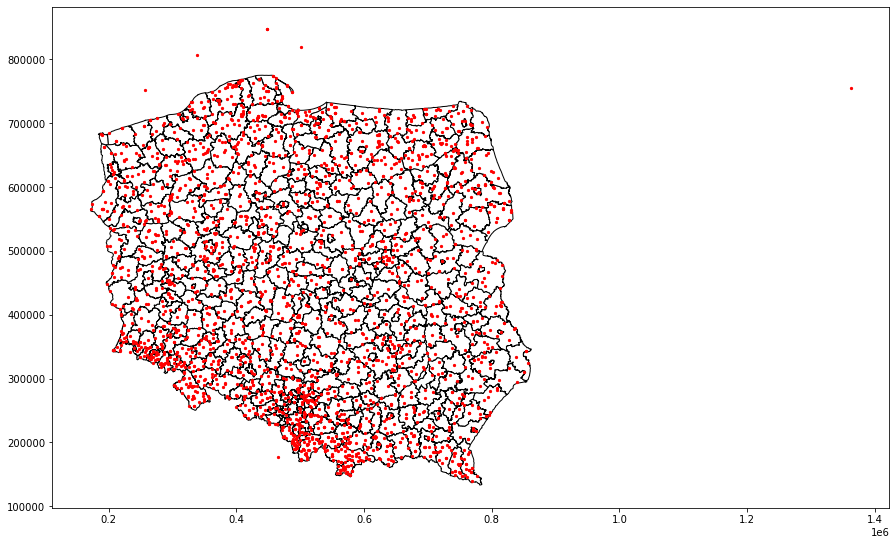

In [60]:
base = powiaty.plot(figsize=(15, 10), color='white', edgecolor='black');
meteo_station.plot(ax=base, marker='o', color='red', markersize=5);